#### Creating a model for the https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification dataset.

In [1]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

# Initial setup for all models.

In [2]:
import sys
import os
import random

import so_ml_tools as soml

import tensorflow as tf
import keras as ks
import pandas as pd
import numpy as np
import opendatasets as od

import tensorflow_hub as hub

from keras import Model
from keras import layers
from keras import losses
from keras import optimizers

2023-09-29 11:50:31.396515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Download Kaggle Card Image Dataset

In [3]:
od.download_kaggle_dataset(dataset_url="https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/download?datasetVersionNumber=2", data_dir="./data")

Skipping, found downloaded files in "./data/cards-image-datasetclassification" (use force=True to force download)


### Inspect Dataset

In [4]:
# List the contents of the ./data directory
!ls ./data

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards-image-datasetclassification


In [5]:
# List the contents of the ./data/cards-image-datasetclassification directory
!ls ./data/cards-image-datasetclassification

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards.csv  test  train	valid


In [6]:
# Delete the two saved models
!rm ./data/cards-image-datasetclassification/*.h5
!ls ./data/cards-image-datasetclassification

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
rm: cannot remove './data/cards-image-datasetclassification/*.h5': No such file or directory
/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards.csv  test  train	valid


In [7]:
TRAIN_DIR = './data/cards-image-datasetclassification/train'
TEST_DIR = './data/cards-image-datasetclassification/test'
VALID_DIR = './data/cards-image-datasetclassification/valid'

In [8]:
soml.util.io.list_dir_summary(folder=TRAIN_DIR)

There are 53 directories, and 0 in ./data/cards-image-datasetclassification/train
There are 0 directories, and 152 in ./data/cards-image-datasetclassification/train/six of clubs
There are 0 directories, and 128 in ./data/cards-image-datasetclassification/train/king of clubs
There are 0 directories, and 161 in ./data/cards-image-datasetclassification/train/queen of clubs
There are 0 directories, and 129 in ./data/cards-image-datasetclassification/train/nine of diamonds
There are 0 directories, and 139 in ./data/cards-image-datasetclassification/train/six of diamonds
There are 0 directories, and 139 in ./data/cards-image-datasetclassification/train/queen of hearts
There are 0 directories, and 151 in ./data/cards-image-datasetclassification/train/ten of diamonds
There are 0 directories, and 151 in ./data/cards-image-datasetclassification/train/king of spades
There are 0 directories, and 126 in ./data/cards-image-datasetclassification/train/three of clubs
There are 0 directories, and 157 i

### Visualize some sample data

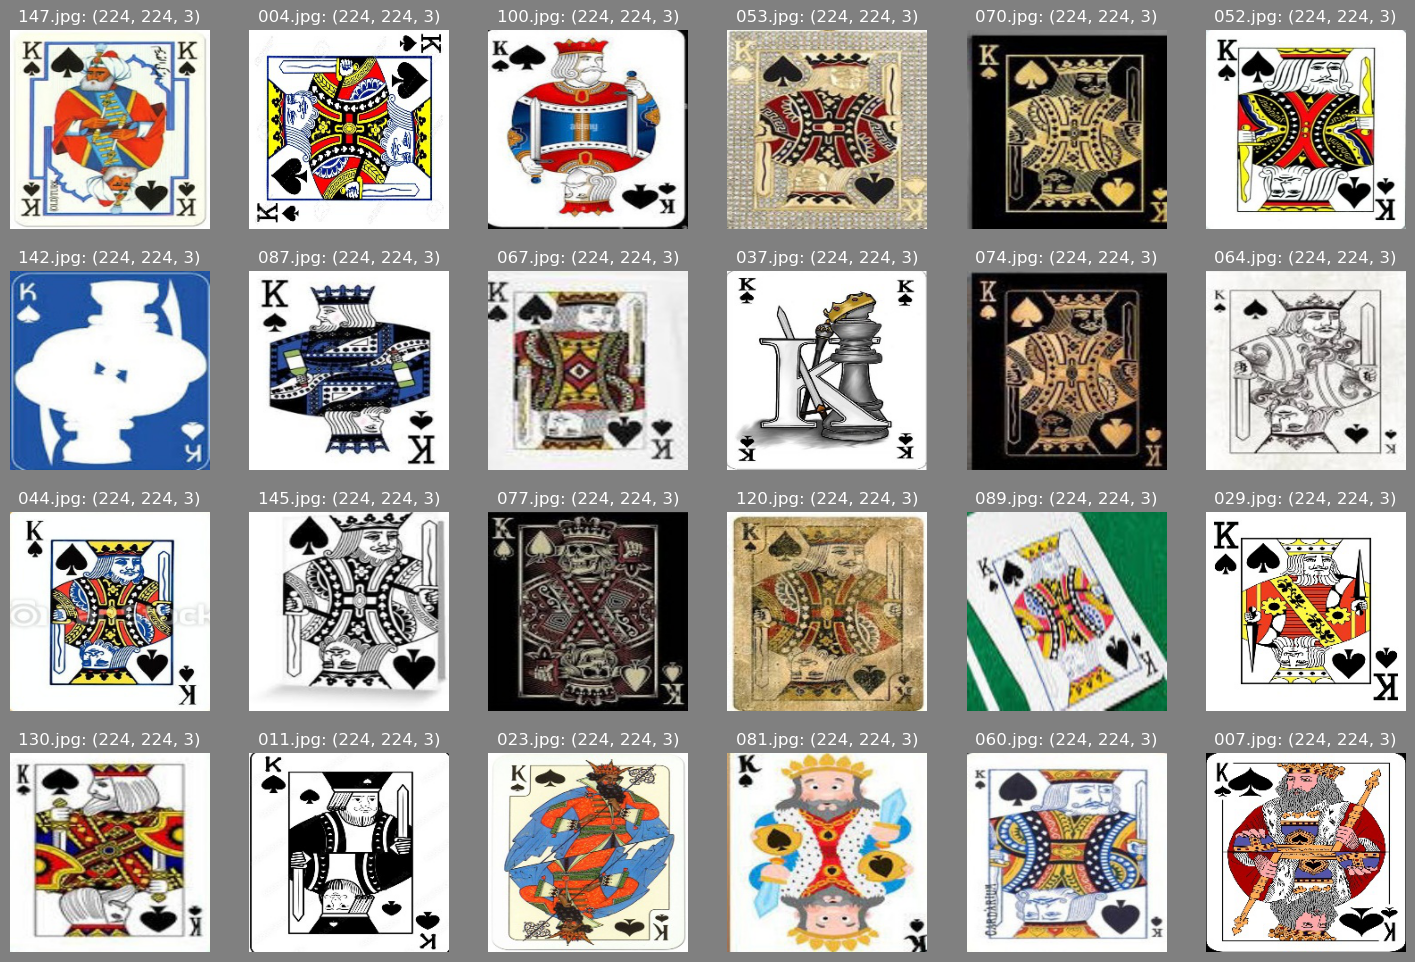

In [9]:
soml.data.image.show_random_image_from_disk(target_dir=TRAIN_DIR, target_class='king of spades')

# Create EfficientNetB0 Model

More details about EfficientNet can be found here:

https://paperswithcode.com/method/efficientnet

### Create datasets

In [10]:
# Set image shape back to 224x224 since the EfficientNetB0 model is based upon this size.
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

# Because we changed the image size we will also need to reload the datasets.
train_dataset = soml.data.loader.load_image_dataset_from_directory(directory=TRAIN_DIR, image_size=IMG_SHAPE, batch_size=BATCH_SIZE)
test_dataset = soml.data.loader.load_image_dataset_from_directory(directory=TEST_DIR, image_size=IMG_SHAPE, batch_size=BATCH_SIZE)
valid_dataset = soml.data.loader.load_image_dataset_from_directory(directory=VALID_DIR, image_size=IMG_SHAPE, batch_size=BATCH_SIZE, shuffle=False)

train_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_shuffling(dataset=soml.tf.dataset.add_caching(dataset=soml.tf.dataset.add_rescaling_mapping(dataset=train_dataset))))
test_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_shuffling(dataset=soml.tf.dataset.add_caching(dataset=soml.tf.dataset.add_rescaling_mapping(dataset=test_dataset))))
valid_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_caching(dataset=soml.tf.dataset.add_rescaling_mapping(dataset=valid_dataset)))

print('\nClass-names:')
class_names = soml.tf.dataset.get_class_names(dataset=train_dataset)
class_names[:10]

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
WARN: Dataset is already shuffled.
Buffer size for shuffle has been set to 1000
WARN: Dataset is already prefetched.
WARN: Dataset is already shuffled.
Buffer size for shuffle has been set to 1000
WARN: Dataset is already prefetched.
WARN: Dataset is already prefetched.

Class-names:


['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds']

In [11]:
soml.tf.dataset.describe_pipeline(dataset=train_dataset)

_PrefetchDataset -> _ShuffleDataset -> CacheDataset -> _MapDataset -> _BatchDataset -> _ShuffleDataset -> _PrefetchDataset -> _ZipDataset

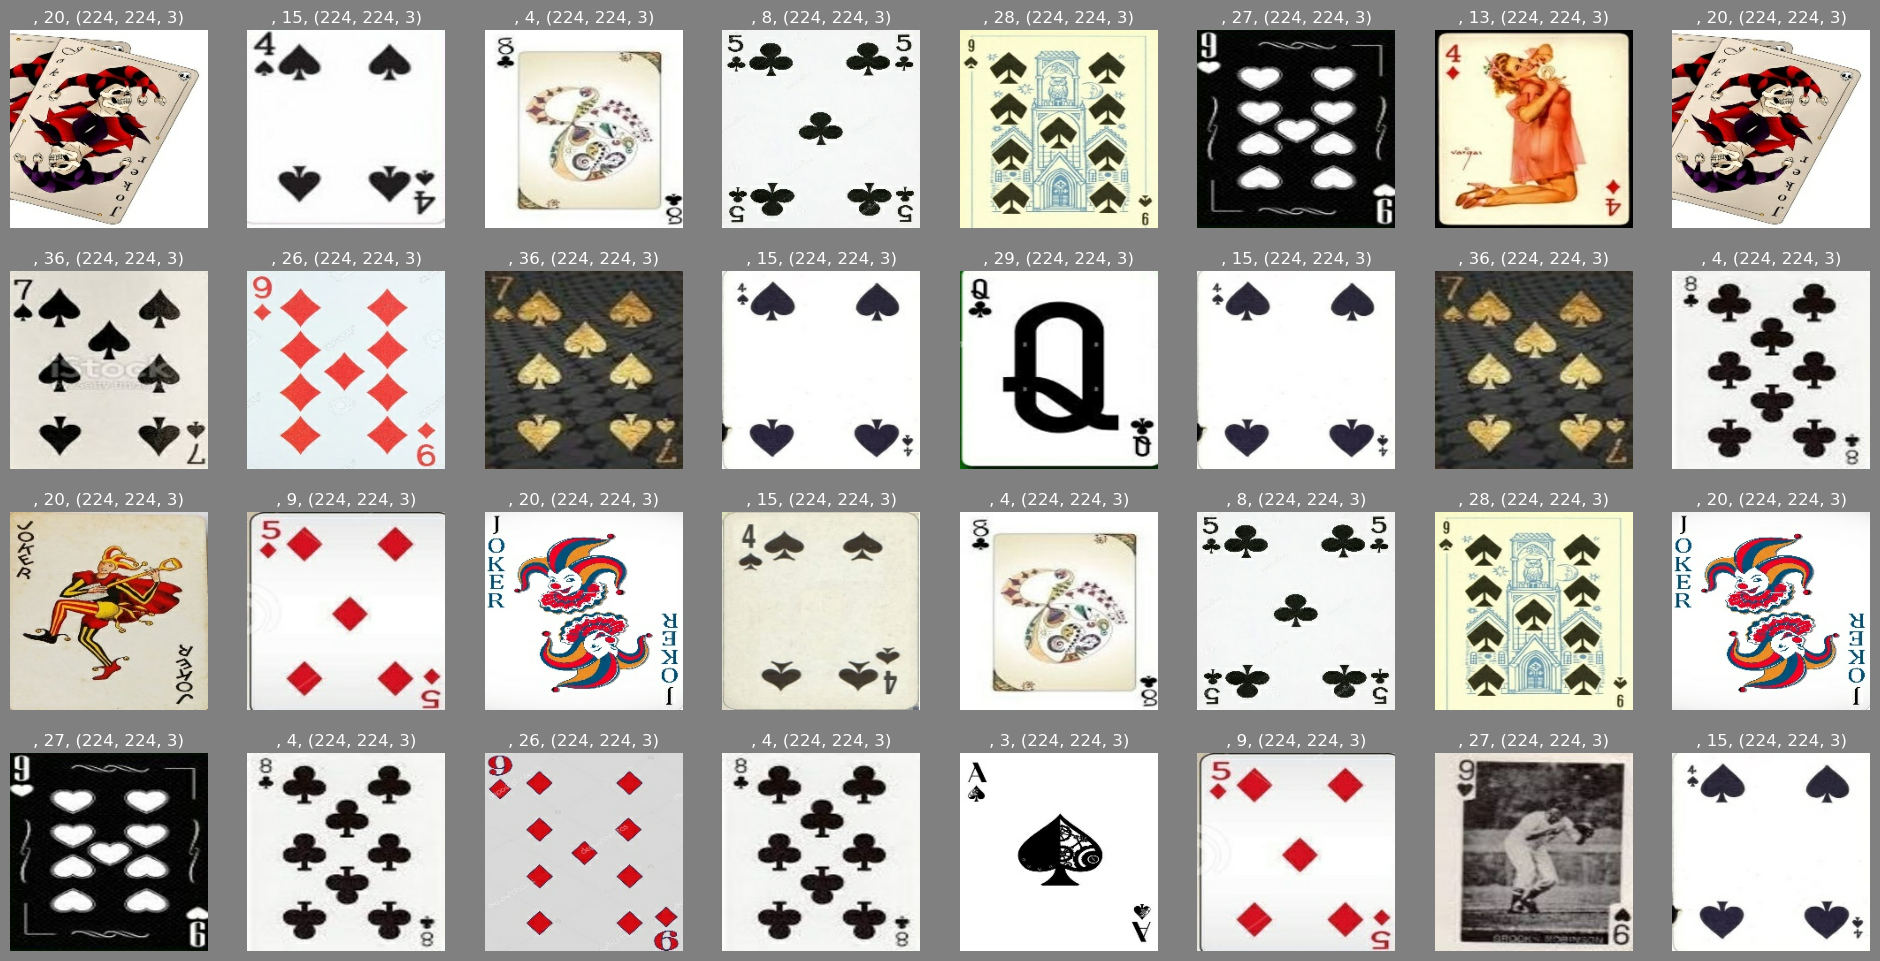

In [12]:
soml.tf.dataset.show_images_from_dataset(train_dataset)

### Perform feature extraction

In [14]:
# Create the EfficientNetB0 base model
vgg16_base_model = tf.keras.applications.vgg16.VGG16(include_top=False)
vgg16_base_model.trainable = False

input_layer = ks.layers.Input(shape=IMG_SHAPE + (3,), name='input_layer')
x = vgg16_base_model(input_layer, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output_layer = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)

vgg16_model = tf.keras.Model(input_layer, output_layer)

# 9. Compile the model
vgg16_model.compile(loss=ks.losses.CategoricalCrossentropy(),
                optimizer=ks.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [15]:
soml.tf.model.inspect.list_model(model=vgg16_model, recursive=True)

row   | name (type)                                     | dtype   | policy  | trainable | output shape            | Total Param # | Trainable Param # | Non-trainable Param #
0     | input_layer            (InputLayer            ) | float32 | float32 | True      | [(None, 224, 224, 3)]   | 0             | 0                 | 0                    
1     | input_1                (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] | 0             | 0                 | 0                    
2     | block1_conv1           (Conv2D                ) | float32 | float32 | False     | (None, None, None, 64)  | 1,792         | 0                 | 1,792                
3     | block1_conv2           (Conv2D                ) | float32 | float32 | False     | (None, None, None, 64)  | 36,928        | 0                 | 36,928               
4     | block1_pool            (MaxPooling2D          ) | float32 | float32 | False     | (None, None, None, 64)  | 0             

In [116]:
reduce_lr_on_plateau_callback = soml.tf.fit.callback.reduce_lr_on_plateau_callback()
early_stopping_callback = soml.tf.fit.callback.early_stopping_callback();
checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name='vgg16_feature_extraction', file_name='./best-weights.hdf5', verbose=0)

vgg16_history_feature_extraction_history = vgg16_model.fit(train_dataset,
                                                  steps_per_epoch=len(train_dataset),
                                                  epochs=10,
                                                  validation_data=test_dataset,
                                                  validation_steps=len(test_dataset),
                                                  callbacks=[reduce_lr_on_plateau_callback, early_stopping_callback, checkpoint_callback])

Epoch 1/10
239/239 [==============================] - 7s 27ms/step - loss: 3.9245 - accuracy: 0.0586 - val_loss: 3.7662 - val_accuracy: 0.0642 - lr: 1.0000e-04
Epoch 2/10
239/239 [==============================] - 6s 27ms/step - loss: 3.5442 - accuracy: 0.1073 - val_loss: 3.4192 - val_accuracy: 0.1132 - lr: 1.0000e-04
Epoch 3/10
239/239 [==============================] - 6s 27ms/step - loss: 3.3262 - accuracy: 0.1556 - val_loss: 3.1879 - val_accuracy: 0.1509 - lr: 1.0000e-04
Epoch 4/10
239/239 [==============================] - 6s 26ms/step - loss: 3.1573 - accuracy: 0.1950 - val_loss: 3.0321 - val_accuracy: 0.1925 - lr: 1.0000e-04
Epoch 5/10
239/239 [==============================] - 6s 25ms/step - loss: 3.0136 - accuracy: 0.2277 - val_loss: 2.9122 - val_accuracy: 0.2264 - lr: 1.0000e-04
Epoch 6/10
239/239 [==============================] - 6s 25ms/step - loss: 2.8856 - accuracy: 0.2613 - val_loss: 2.7795 - val_accuracy: 0.2868 - lr: 1.0000e-04
Epoch 7/10
239/239 [====================

### Set last 40 layers to trainable.

In [117]:
# Recompile the model with the default learning rate.
vgg16_model.compile(loss=ks.losses.CategoricalCrossentropy(),
                optimizer=ks.optimizers.Adam(),
                metrics=["accuracy"])

# Load weights after recompile, since recompile sets all weights to random.
soml.tf.model.io.load_weights(model=vgg16_model, filepath='./checkpoints/vgg16_feature_extraction/best-weights.hdf5')

In [118]:
vgg16_base_model.trainable = True
# soml.tf.model.layer.set_trainable_on_layers(model=vgg16_base_model, trainable=False)
# soml.tf.model.layer.set_trainable_on_last_n_layers(model=vgg16_base_model, n=15, trainable=True)
soml.tf.model.inspect.list_model(model=vgg16_base_model, recursive=True)

row   | name (type)                 | dtype   | policy  | trainable | output shape            | Total Param # | Trainable Param # | Non-trainable Param #
0     | input_8      (InputLayer  ) | float32 | float32 | True      | [(None, None, None, 3)] | 0             | 0                 | 0                    
1     | block1_conv1 (Conv2D      ) | float32 | float32 | True      | (None, None, None, 64)  | 1,792         | 1,792             | 0                    
2     | block1_conv2 (Conv2D      ) | float32 | float32 | True      | (None, None, None, 64)  | 36,928        | 36,928            | 0                    
3     | block1_pool  (MaxPooling2D) | float32 | float32 | True      | (None, None, None, 64)  | 0             | 0                 | 0                    
4     | block2_conv1 (Conv2D      ) | float32 | float32 | True      | (None, None, None, 128) | 73,856        | 73,856            | 0                    
5     | block2_conv2 (Conv2D      ) | float32 | float32 | True      | (None,

In [119]:
vgg16_history = vgg16_model.fit(train_dataset,
                                                  steps_per_epoch=len(train_dataset),
                                                  epochs=50,
                                                  validation_data=test_dataset,
                                                  validation_steps=len(test_dataset),
                                                  initial_epoch=vgg16_history_feature_extraction_history.epoch[-1] + 1,
                                                  callbacks=[reduce_lr_on_plateau_callback, early_stopping_callback])

Epoch 11/50
239/239 [==============================] - 7s 26ms/step - loss: 2.2474 - accuracy: 0.4235 - val_loss: 2.1825 - val_accuracy: 0.3849 - lr: 0.0010
Epoch 12/50
239/239 [==============================] - 6s 25ms/step - loss: 1.8156 - accuracy: 0.5382 - val_loss: 1.7900 - val_accuracy: 0.4642 - lr: 0.0010
Epoch 13/50
239/239 [==============================] - 6s 24ms/step - loss: 1.5422 - accuracy: 0.5960 - val_loss: 1.7187 - val_accuracy: 0.5585 - lr: 0.0010
Epoch 14/50
239/239 [==============================] - 6s 25ms/step - loss: 1.3527 - accuracy: 0.6413 - val_loss: 1.5616 - val_accuracy: 0.5887 - lr: 0.0010
Epoch 15/50
239/239 [==============================] - 6s 25ms/step - loss: 1.2085 - accuracy: 0.6730 - val_loss: 1.6228 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 16/50
239/239 [==============================] - 6s 25ms/step - loss: 1.0987 - accuracy: 0.6990 - val_loss: 1.5873 - val_accuracy: 0.5660 - lr: 0.0010
Epoch 17/50
239/239 [==============================] - 6s 

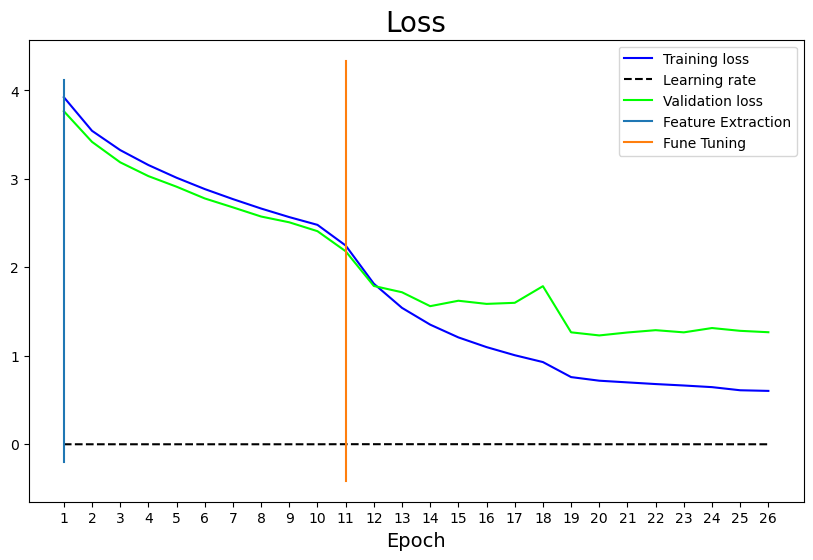

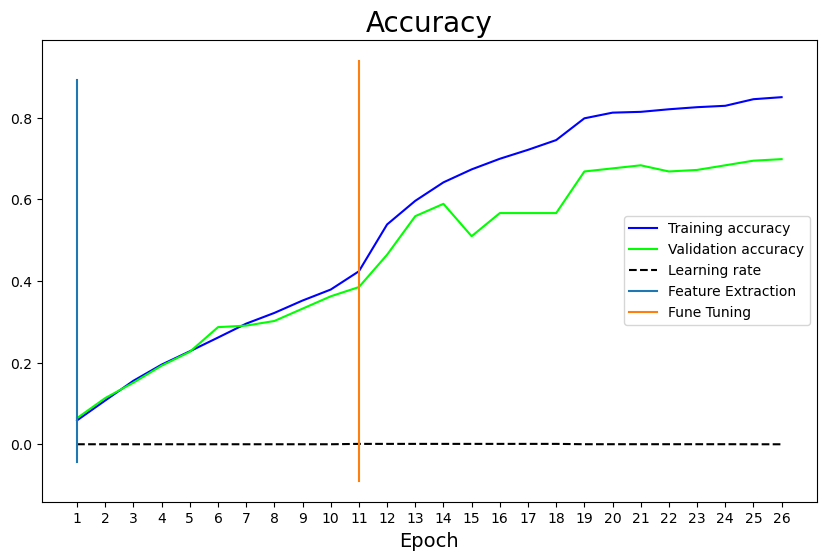

In [125]:
soml.tf.model.plot.plot_consecutive_histories(histories=[vgg16_history_feature_extraction_history, vgg16_history], labels=['Feature Extraction', 'Fune Tuning'])

In [126]:
y_prob = vgg16_model.predict(valid_dataset)
len(y_prob)

9/9 [==============================] - 0s 23ms/step


265

In [127]:
y_true = soml.tf.dataset.get_labels(dataset=valid_dataset)
len(y_true)

265

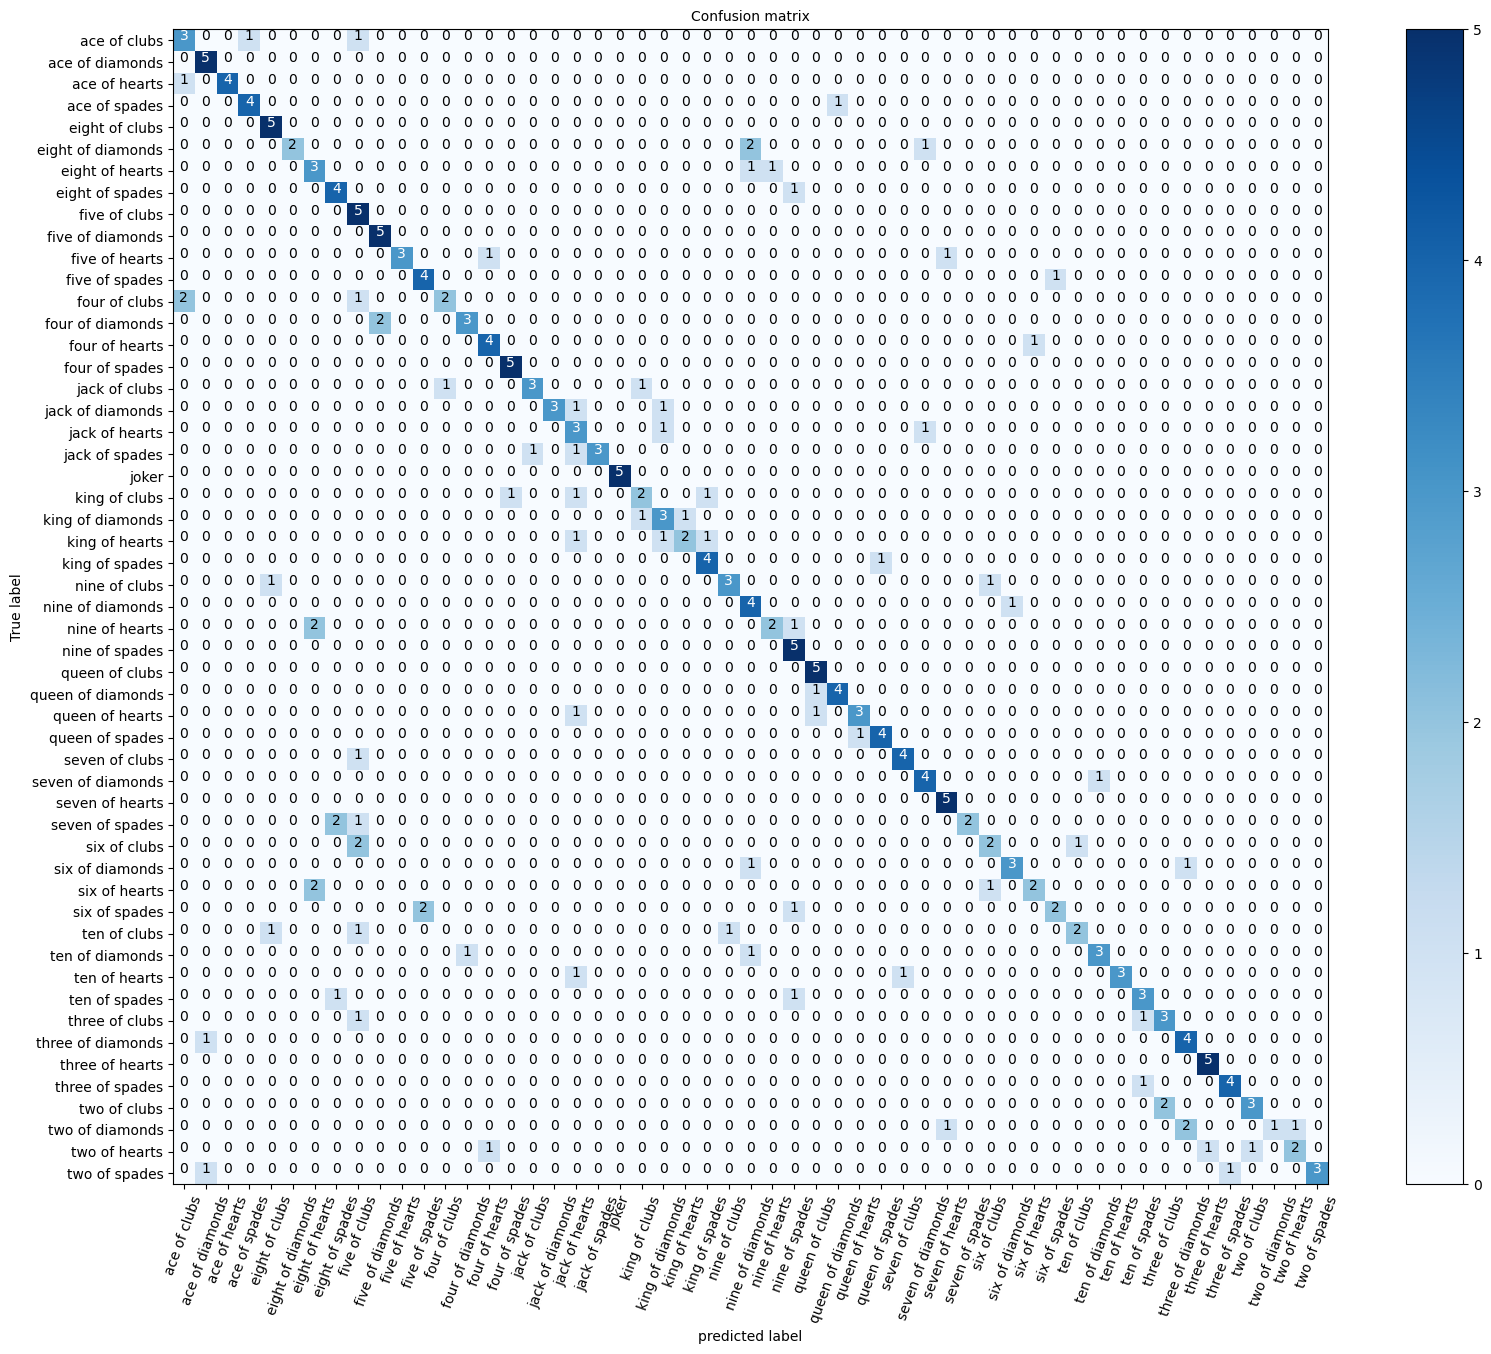

In [128]:
soml.evaluate.plot.confusion_matrix(y_true=y_true, y_prob=y_prob, class_names=class_names, figsize=(20, 15))

In [129]:
soml.evaluate.analyze.quality_metrics(y_true=y_true, y_prob=y_prob)

accuracy  f1-score  precision    recall
0  67.54717  0.669031   0.722845  0.675472